# Stream simulation

We provide some examples for using the `stream` package for running simulations of GD-1. Simulations are made using the code `stream.simulate()`, which returns a list of phase space trajectories for $N$ stars. By default, `stream.simulate()` runs a simulation with default parameters, including a single perturbing subhalo described by the Bonaca-Hernquist profile.

Another useful module is the `coordinates` module, which transforms from galactocentric coordinates to celestial coordinates (especially, the sky positions $\phi_1$-$\phi_2$).

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import pandas as pd
import os
# from mpi4py import MPI

import stream

In [11]:
# Retrieve num_data from environment variable in bash-script
# num_data = int(os.getenv("num_data", "0"))  # Default = 0

In [12]:
num_data = 0

## Subhalo profiles

Alternative profiles can be specified using the keyword `subhalo_profile_type`. 
Currently the following profiles are allowed:
- tNFW (`subhalo_profile_type='tNFW'`): Also needs keyword `M_subhalo` to be set.
- Hernquist (`subhalo_profile_type='Hern')`: Also needs keyword `M_subhalo` to be set.
- SIDM from Jeans model (`subhalo_profile_type='Jeans')`: Also needs keywords `M_subhalo` and `sigma_m` to be set.
- SIDM5 from numerical grid of profile data (`subhalo_profile_type='SIDM5')`: Also needs keywords `M_subhalo`.
- Custom numerical profile (`subhalo_profile_type='numerical'`): Also needs keywords `M` and `r` to be set, as equal-length arrays.

Updated subhalo list:

- tNFW: `subhalo_profile_type='tNFW'`
- Cored profiles (SIDM with 5 cm²/g): `subhalo_profile_type='SIDM5_sph'`
- Super-cuspy profiles for dissipative SIDM: `subhalo_profile ='DSIDM553_sph'`

In [13]:
# Chose subhalo profile
subhalo_profile = 'SIDM5_sph'

## Import data

In [14]:
data = pd.read_csv('../data/subhalo/Multiple_subhalo_impacts_samples.csv')

In [15]:
# Chose section and subhalos with t < 2 Gyr
filtered_data = data[(data['num'] == num_data) & (data['t_since_impact'] <= 2)]

# Assign parameter
M_subhalo = data['M_subhalo'].values
impact_position = data['fimp'].values
b_impact_param = data['b'].values
t_since_impact = data['t_since_impact'].values
delta_logc = data['delta_logc'].values
phi_impact = data['phi'].values
theta_impact = data['theta'].values
v_subhalo = data['v_subhalo'].values

# Print data
# print(filtered_data)

## Create list

In [16]:
# Create subhalo list
subhalo_list = []

for _, row in filtered_data.iterrows():
    subhalo = {
        'M_subhalo': row['M_subhalo'],
        'impact_position': row['fimp'],
        'b_impact_param': row['b'],
        't_since_impact': row['t_since_impact'],
        'delta_logc': row['delta_logc'],
        'phi_impact': row['phi'],
        'theta_impact': row['theta'],
        'v_subhalo': row['v_subhalo']
    }
    subhalo_list.append(subhalo)

In [17]:
for subhalo in subhalo_list:
    subhalo['subhalo_profile_type'] = subhalo_profile

## Simulate

In [18]:
tr = stream.simulate(subhalo_list=subhalo_list,verbose=False)
# tr = stream.simulate(subhalo_list=subhalo_list,verbose=False)

## Multiprocessing

By default, `stream.simulate()` makes a linear uniformly-distributed stream. A more realistic stream can be made by setting the keyword `star_distribution='random'`. One can also increase the number of stars by setting the `num_stars` keyword (the default is 100). 

The simulation time increases with the number of stars. This can be circumvented by running multiple simulations in parallel and combining the results into one stream. Remember to set `random_seed` to be different for each parallel process, otherwise you will get copies of the same random stream.

Here we will get a respectable stream of 2000 stars by running 8 simulations in parallel.

In [10]:
# inputs = [{'star_distribution':'random','random_seed':n, 'subhalo_list':subhalo_list, 'num_stars':250} for n in range(8)]

# inputs = [{'star_distribution':'random',
#            'random_seed':n,
#            'subhalo_profile_type':'SIDM5',
#            'M_subhalo':1e7,
#            'num_stars':250} for n in range(8)]

# num_processes = 20

# Divide one stream simulation into parallel simulations
# with Pool(num_processes) as p:
#     output = p.map(stream.simulate,inputs)
    
# Put all trajectories together
# tr = np.concatenate(output)
# pos = stream.coordinates.transform(tr)

In [11]:
num_processes = 2

inputs = [{'star_distribution':'random', 'random_seed':n, 'subhalo_list':subhalo_list, 'num_stars':20} for n in range(num_processes)]

# inputs = [{'star_distribution':'random',
#            'random_seed':n,
#            'subhalo_profile_type':'SIDM5',
#            'M_subhalo':1e7,
#            'num_stars':250} for n in range(8)]

# Divide one stream simulation into parallel simulations
with Pool(num_processes) as p:
    output = p.map(stream.simulate, inputs)

# Put all trajectories together
tr = np.concatenate(output)
pos = stream.coordinates.transform(tr)

On the cluster, we use MPI to distribute the parallel processes on different nodes of the cluster such that one process runs on one node. 

In [26]:
# Initialize MPI
# comm = MPI.COMM_WORLD
# rank = comm.Get_rank()  # Current rank
# size = comm.Get_size()  # Number of processes

# Number of simulations
# num_simulations = 8

# Generate inputs
# inputs = [{'star_distribution': 'random', 'random_seed': rank, 'subhalo_list':subhalo_list, 'num_stars': 250} for rank in range(num_simulations)]

# Divide the stream simulation into parallel simulations
# output = stream.simulate(inputs[rank])

# Put results together
# all_outputs = comm.gather(output, root=0)  

# if rank == 0:
    # Put trajectories together
#     tr = np.concatenate(all_outputs)
#     pos = stream.coordinates.transform(tr)

## Plot and save

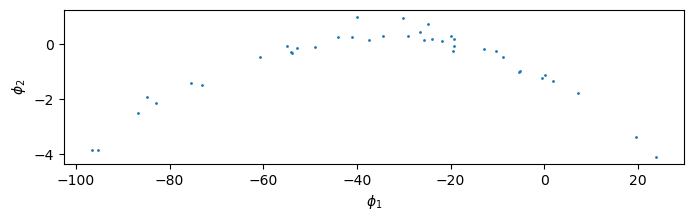

In [12]:
# Show and save stream plot

plt.figure(figsize=(8,2))

plt.plot(pos['phi1'],pos['phi2'],'.',markersize=2)

plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_2$')
plt.savefig(f'../results/{subhalo_profile}/stream_simulation_section{num_data}.pdf')
plt.show()

In [13]:
# Save trajectories data

np.savez(f'../results/{subhalo_profile}/stream_trajectories_section{num_data}.npz', tr=tr)

In [14]:
# Show stream trajectories data
# Load
# data = np.load(f'../results/tNFW/stream_trajectories_section{num_data}.npz')

# Show
# for key in data:
#     print(f"Key '{key}':\n", data[key], "\n")

In [15]:
# Lade die .npz-Datei
data = np.load(f'../results/{subhalo_profile}/stream_trajectories_section{num_data}.npz')

# Überprüfe, welche Arrays in der Datei gespeichert sind
print(data.files)

# Extrahiere das Array 'tr' (oder welches auch immer du gespeichert hast)
tr = data['tr']

# Zeige das Array an
print(tr)


['tr']
[[[-2.00000000e+00  1.01854168e+01 -3.48765860e+00 -8.88633140e+00
    8.60367849e+01  2.63232364e+02  2.13229883e+01]
  [ 0.00000000e+00 -1.06498152e+01  3.83535216e+00  8.08915351e+00
   -1.35870710e+02 -2.30631650e+02 -7.73679373e+01]]

 [[-2.00000000e+00  1.04457457e+01 -2.66126577e+00 -8.80849456e+00
    7.99555261e+01  2.64688004e+02  2.92738437e+01]
  [ 0.00000000e+00 -1.20732956e+01  1.18050188e+00  6.88347234e+00
   -1.05963967e+02 -2.36253675e+02 -1.01320558e+02]]

 [[-2.00000000e+00  1.05235033e+01 -2.39827359e+00 -8.77958558e+00
    7.81190490e+01  2.64817978e+02  3.20205683e+01]
  [ 0.00000000e+00 -1.23742830e+01  5.47980590e-01  6.61057094e+00
   -9.88080670e+01 -2.36017524e+02 -1.06260968e+02]]

 [[-2.00000000e+00  1.15321864e+01  2.47763693e+00 -7.89142125e+00
    3.50897635e+01  2.67827945e+02  6.64110169e+01]
  [ 0.00000000e+00 -1.01523405e+01  4.64573646e+00  8.26733563e+00
   -1.46201738e+02 -2.28641028e+02 -7.09931394e+01]]

 [[-2.00000000e+00  1.16058024e+0

In [16]:
print(tr.shape)

(40, 2, 7)


In [19]:
# Test

test = tr[1,-1,1]
print(test)

-12.073295588117672


In [ ]:
def transform(tr, rsun=[-8,0,0],vsun=[]):

    # number of stars
    num_stars = len(tr)
    
    # Galactocentric coords
    x = tr[:,-1,1]
    y = tr[:,-1,2]
    z = tr[:,-1,3]

    v_x = tr[:,-1,4]
    v_y = tr[:,-1,5]
    v_z = tr[:,-1,6]
    
    #Determine galactocentric coordinates relative to sun
    xrel = np.array( x - rsun[0] )
    yrel = np.array( y - rsun[1] )
    zrel = np.array( z - rsun[2] )

In [15]:
# Data output for the power spectrum

data_power_spectrum = pd.DataFrame(pos['phi1'], columns=['x'])
# simulation_data = f'../results/{subhalo_profile}/data_output_power_section{num_data}.csv'
simulation_data = f'../results/{subhalo_profile}/data_output_power_section_test{num_data}.csv'

data_power_spectrum.to_csv(simulation_data, index=False) 